# Regresión entre series y regresiones con lag.

In [1]:
## Ejemplo: instalación de astsadata usando pip:
#!pip install astsadata
#Importo astsadata
import warnings
with warnings.catch_warnings(action="ignore"):
    import astsadata as astsa

## Ajusto tamaño de figuras
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15,5]
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.constrained_layout.use'] = True

En el cuaderno anterior vimos el el **Modelo de Regresión Lineal:**

$$x_t = \beta_1z_{t_1} + \ldots + \beta_qz_{t_q} + w_t.$$

En el modelo:

* $\beta_1\ldots\beta_q$ son los parámetros a ajustar
* $z_{t_i}$ son las funciones de regresión a usar, evaluadas en cada $t$.
* $w_t$ es ruido blanco (gaussiano) de varianza $\sigma_w^2$. 

Usando el comando `ols` de `statsmodels.formula.api` se ajustan modelos lineales como el anterior.

Vimos además algunos de sus usos:

 * Ajustar funciones de tendencia a series temporales.
 * Hacer regresión con "factores" que representen fenómenos especiales (ej: trimestres), (Ejercicio 1).
 * Ajustar componentes periódicas (Ejercicio 2)...más sobre esto en este cuaderno.
 
 
Queremos ahora estudiar:

 * El uso de modelos lineales para hallar relaciones *entre series* que permitan explicar una a partir de otra.
 * Cómo ajustar componentes periódicas o estacionales. En particular cómo determinar sus frecuencias.
 * Algunos casos de regresión no lineal.

## Ejemplo: relación entre mortalidad, temperatura y polución.

El ejemplo, tomado del libro de Shumway, consiste en tres series:

* $M_t = $ mortalidad cardiovascular semanal reportada en Los Angeles durante 10 años.
* $T_t = $ temperatura media registrada en Farenheit.
* $P_t = $ conteo de niveles de partículas en el aire.

Grafiquemos las 3 series:


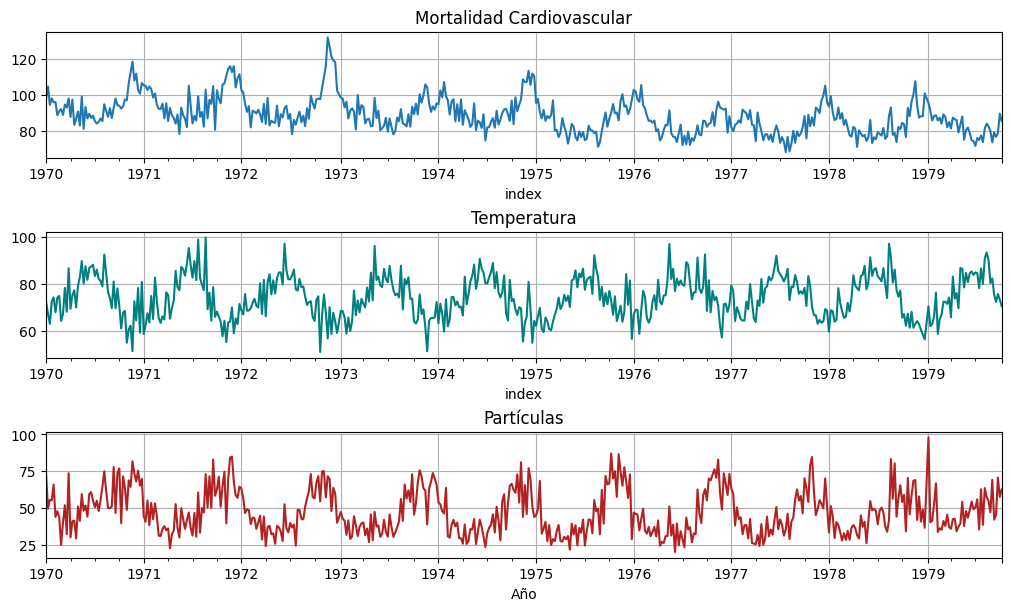

In [2]:
M=astsa.cmort
T=astsa.tempr
P=astsa.part

fig, axs = plt.subplots(3, 1, figsize=[10,6])
M.plot(ax=axs[0], title="Mortalidad Cardiovascular", legend=False)
T.plot(ax=axs[1], title="Temperatura", color="teal", legend=False);
P.plot(ax=axs[2], xlabel="Año", title="Partículas", color="firebrick", legend=False);

**Observaciones:**

* Se ve una tendencia decreciente de mortalidad.
* Se ven ciclos estacionales claros (anuales)
* Mortalidad y temperatura parecen estar "en contrafase" -> la gente muere más en invierno?
* Temperatura y partículas parecen estar "en contrafase" también -> la lluvia en invierno limpia?

Para analizar estas relaciones se puede hacer un gráfico de correlaciones, con el comando `scatter_matrix` de `pandas.plotting`.

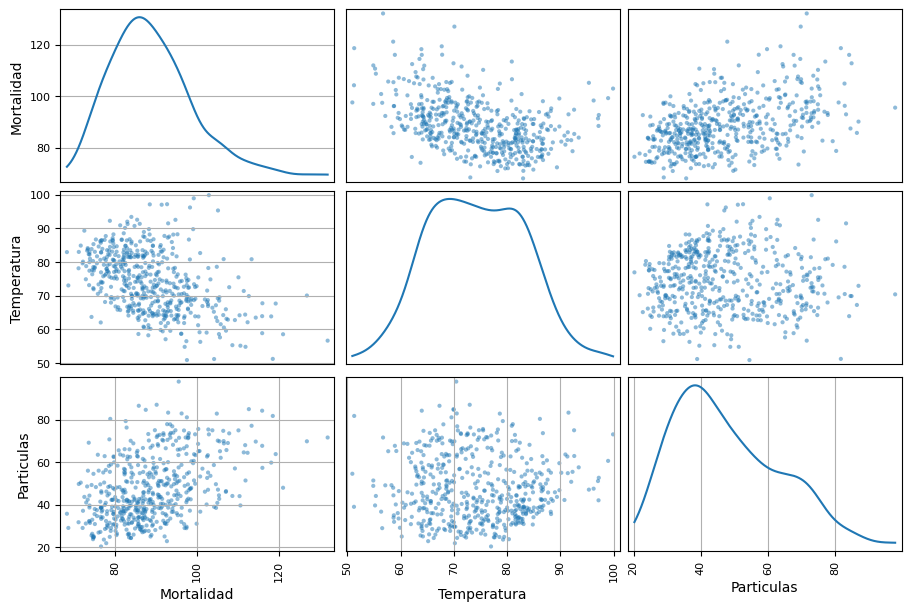

In [3]:
import pandas as pd
import numpy as np
import scipy as sp

data = pd.concat([M, T, P], axis=1)
data.columns = ["Mortalidad", "Temperatura", "Particulas"]

pd.plotting.scatter_matrix(data, figsize=(9, 6), diagonal="kde") #kde pone estimaciones de la densidad en la diagonal
plt.show()

Se propone entonces ajustar algunos modelos que buscan explicar la serie de mortalidad *a partir de las otras*:

1. $M_t = \beta_0 + \beta_1 t + w_t.$
2. $M_t = \beta_0 + \beta_1 t + \beta_2(T_t - \bar{T}) + w_t.$
3. $M_t = \beta_0 + \beta_1 t + \beta_2(T_t - \bar{T}) + \beta_3(T_t - \bar{T})^2 + w_t.$
4. $M_t = \beta_0 + \beta_1 t + \beta_2(T_t - \bar{T}) + \beta_3(T_t - \bar{T})^2 + \beta_4 P_t + w_t.$


### Modelo 1

In [4]:
import statsmodels.api as sm #para el qqplot
from statsmodels.formula.api import ols

time = pd.Series([idx.ordinal for idx in M.index], index=M.index, name="Semana")
datos = pd.concat([time,M], axis=1)
datos.columns = ["Semana","Mortalidad"]

fit = ols(formula="M~Semana", data=datos).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      M   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     135.0
Date:                Tue, 22 Apr 2025   Prob (F-statistic):           8.03e-28
Time:                        15:38:03   Log-Likelihood:                -1829.9
No. Observations:                 508   AIC:                             3664.
Df Residuals:                     506   BIC:                             3672.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     96.6510      0.790    122.335      0.000      95.099      98.203
Semana        -0.0312      0.003    -11.618      0.000      -0.036      -0.026
==============================================================================
Omnibus:                       67.579   Durbin-Watson:                   0.576
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.699
Skew:                           0.906   Prob(JB):                     6.09e-22
Kurtosis:                       4.156   Cond. No.                         590.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

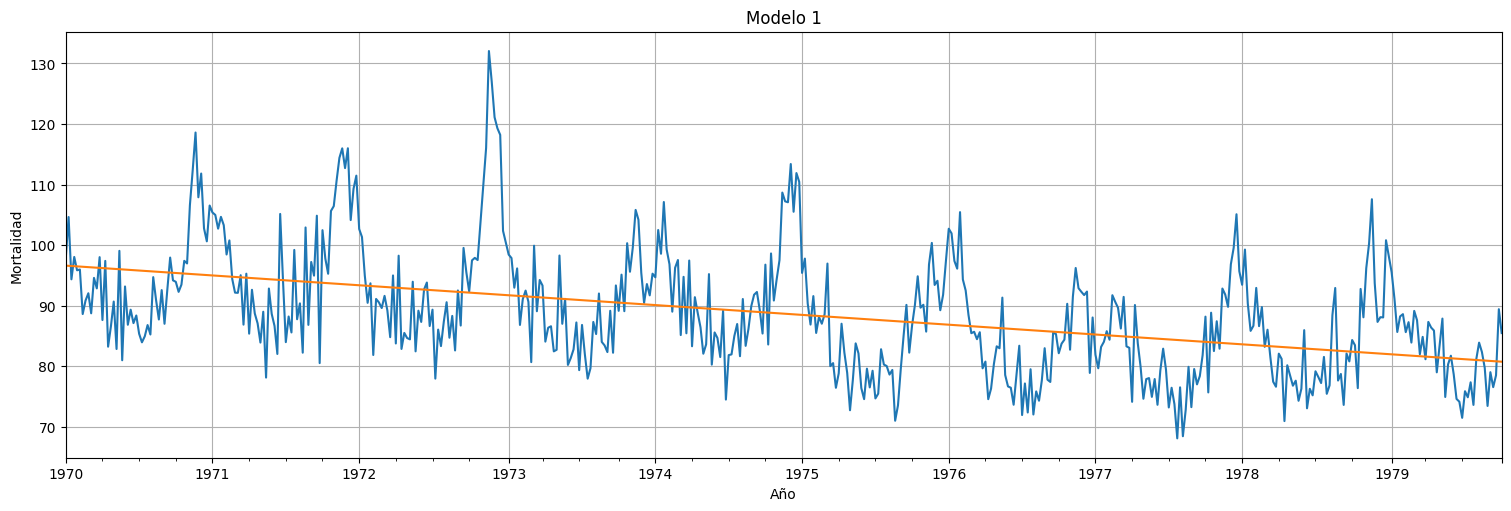

In [5]:
ax = M.plot(xlabel="Año", ylabel="Mortalidad", legend=False)
ax.plot(fit.fittedvalues)
plt.title("Modelo 1")
plt.ylabel("Mortalidad")
plt.xlabel("Año");

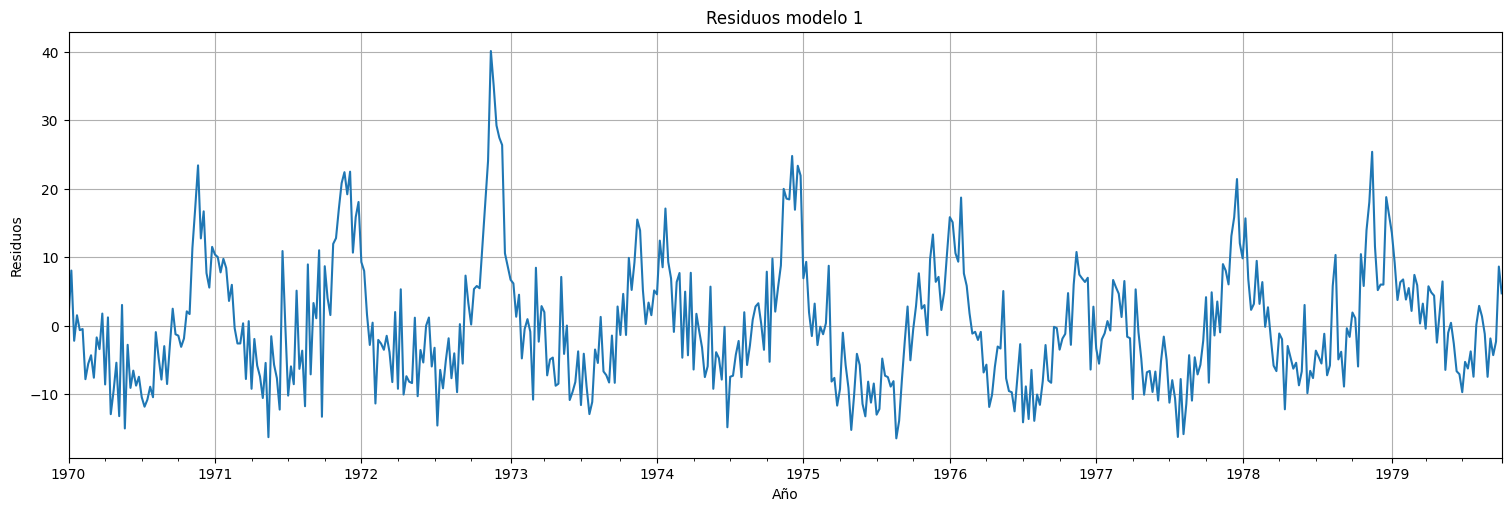

In [6]:
fit.resid.plot()
plt.title("Residuos modelo 1")
plt.ylabel("Residuos")
plt.xlabel("Año");

### Modelo 2

In [7]:
#  Modelo 2
temp  = T-np.mean(T)           # temperatura centrada

datos = pd.concat([time,M, temp], axis=1)
datos.columns = ["Semana","Mortalidad", "Temperatura"]

fit = ols(formula="M~Semana+Temperatura", data=datos).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      M   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     155.0
Date:                Tue, 22 Apr 2025   Prob (F-statistic):           3.28e-53
Time:                        15:38:03   Log-Likelihood:                -1768.4
No. Observations:                 508   AIC:                             3543.
Df Residuals:                     505   BIC:                             3555.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      96.2251      0.702    137.154      0.000      94.847      97.604
Semana         -0.0295      0.002    -12.377      0.000      -0.034      -0.025
Temperatura    -0.4579      0.039    -11.763      0.000      -0.534      -0.381
==============================================================================
Omnibus:                       58.204   Durbin-Watson:                   1.214
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.792
Skew:                           0.818   Prob(JB):                     2.86e-18
Kurtosis:                       4.068   Cond. No.                         591.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

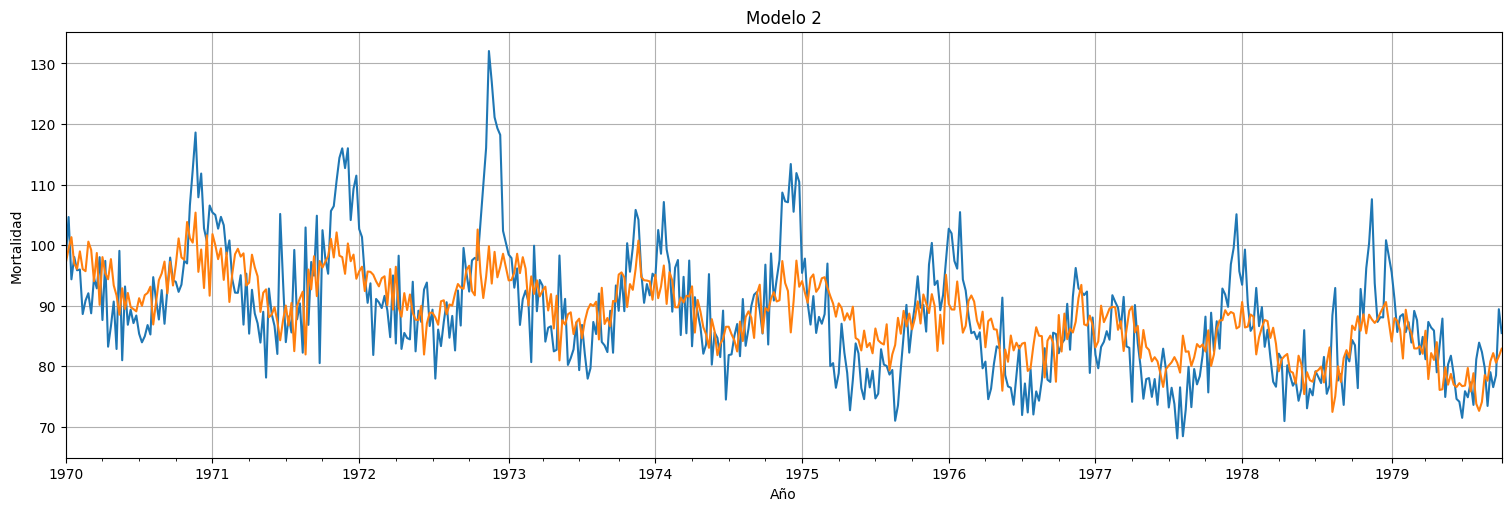

In [8]:
ax = M.plot(xlabel="Año", ylabel="Mortalidad", legend=False)
ax.plot(fit.fittedvalues)
plt.title("Modelo 2")
plt.ylabel("Mortalidad")
plt.xlabel("Año");

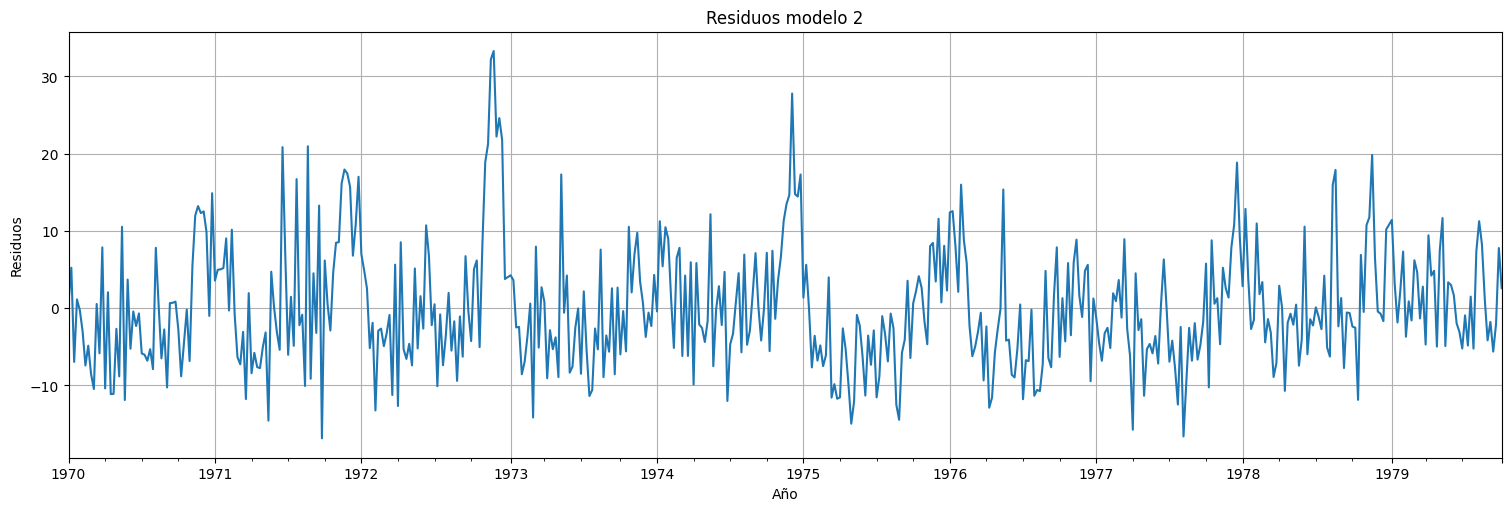

In [9]:
fit.resid.plot()
plt.title("Residuos modelo 2")
plt.ylabel("Residuos")
plt.xlabel("Año");

### Modelo 3

In [10]:
temp2 = temp**2              # cuadrados

datos = pd.concat([time,M, temp, temp2], axis=1)
datos.columns = ["Semana","Mortalidad", "Temperatura", "Temperatura2"]

fit = ols(formula="Mortalidad~Semana+Temperatura+Temperatura2", data=datos).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Mortalidad   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     136.3
Date:                Tue, 22 Apr 2025   Prob (F-statistic):           1.14e-64
Time:                        15:38:03   Log-Likelihood:                -1739.1
No. Observations:                 508   AIC:                             3486.
Df Residuals:                     504   BIC:                             3503.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       93.9179      0.725    129.543      0.000      92.493      95.342
Semana          -0.0286      0.002    -12.714      0.000      -0.033      -0.024
Temperatura     -0.4808      0.037    -13.032      0.000      -0.553      -0.408
Temperatura2     0.0258      0.003      7.857      0.000       0.019       0.032
==============================================================================
Omnibus:                       64.188   Durbin-Watson:                   1.326
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.520
Skew:                           0.826   Prob(JB):                     2.45e-22
Kurtosis:                       4.405   Cond. No.                         666.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

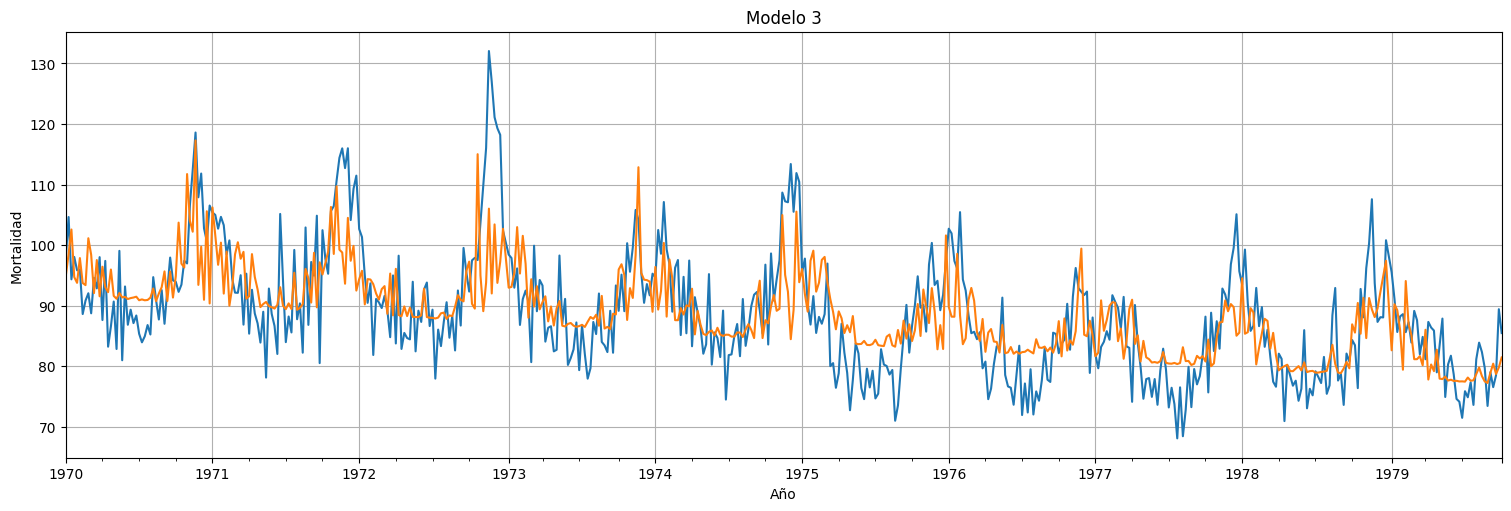

In [11]:
ax = M.plot(xlabel="Año", ylabel="Mortalidad", legend=False)
ax.plot(fit.fittedvalues)
plt.title("Modelo 3")
plt.ylabel("Mortalidad")
plt.xlabel("Año");

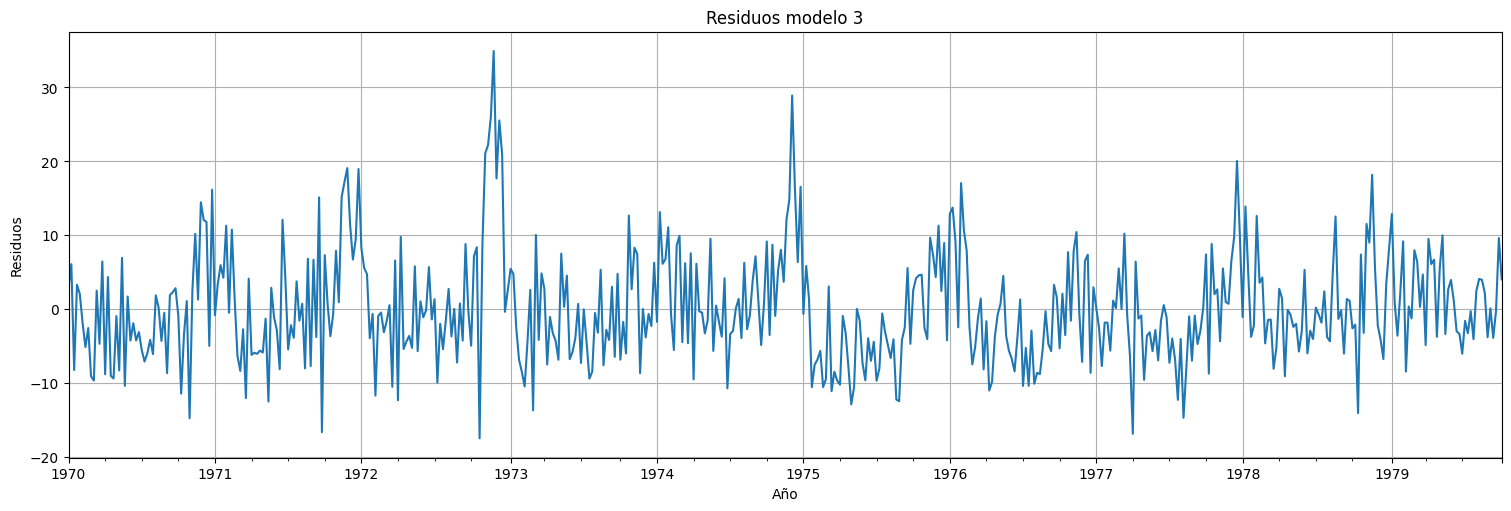

In [12]:
fit.resid.plot()
plt.title("Residuos modelo 3")
plt.ylabel("Residuos")
plt.xlabel("Año");

### Modelo 4

In [13]:
datos = pd.concat([time,M, temp, temp2, P-np.mean(P)], axis=1)
datos.columns = ["Semana","Mortalidad", "Temperatura", "Temperatura2", "Particulas"]

fit = ols(formula="Mortalidad~Semana+Temperatura+Temperatura2+Particulas", data=datos).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Mortalidad   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     185.1
Date:                Tue, 22 Apr 2025   Prob (F-statistic):           2.20e-97
Time:                        15:38:04   Log-Likelihood:                -1660.1
No. Observations:                 508   AIC:                             3330.
Df Residuals:                     503   BIC:                             3351.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       93.6979      0.622    150.760      0.000      92.477      94.919
Semana          -0.0268      0.002    -13.821      0.000      -0.031      -0.023
Temperatura     -0.4725      0.032    -14.941      0.000      -0.535      -0.410
Temperatura2     0.0226      0.003      7.989      0.000       0.017       0.028
Particulas       0.2553      0.019     13.539      0.000       0.218       0.292
==============================================================================
Omnibus:                       47.363   Durbin-Watson:                   1.311
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.807
Skew:                           0.661   Prob(JB):                     6.94e-16
Kurtosis:                       4.245   Cond. No.                         666.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

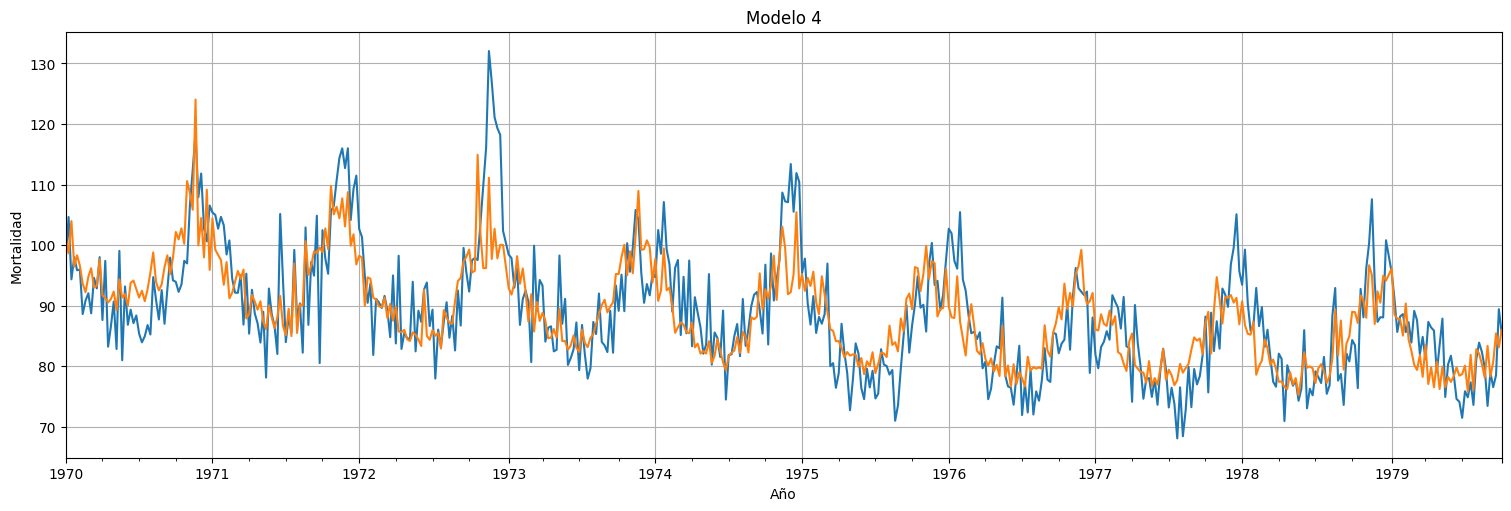

In [14]:
ax = M.plot(xlabel="Año", ylabel="Mortalidad", legend=False)
ax.plot(fit.fittedvalues)
plt.title("Modelo 4")
plt.ylabel("Mortalidad")
plt.xlabel("Año");

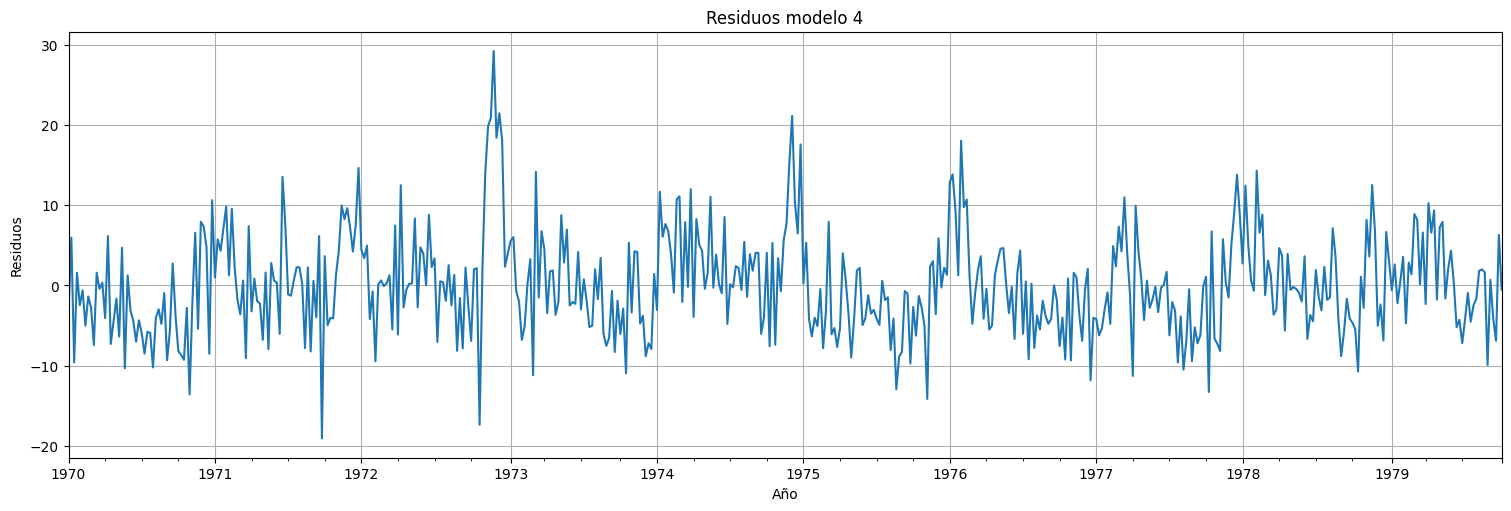

In [15]:
fit.resid.plot()
plt.title("Residuos modelo 4")
plt.ylabel("Residuos")
plt.xlabel("Año");

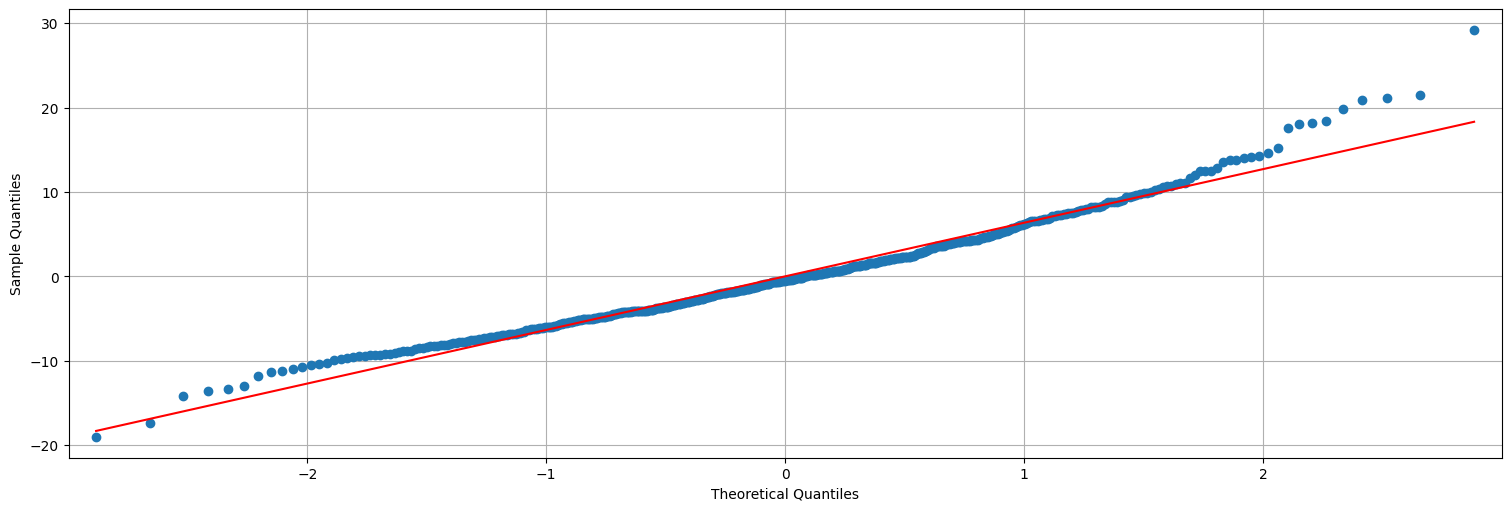

In [16]:
## QQ-plot es una verificación de gaussianidad.
sm.qqplot(fit.resid, line="s");

> **Nota:**
> 
> Para calcular la acf, conviene utilizar `statsmodels.tsa.graphics.plot_acf()` con la opción `bartlett_confint=False` para usar el intervalo de confianza correcto

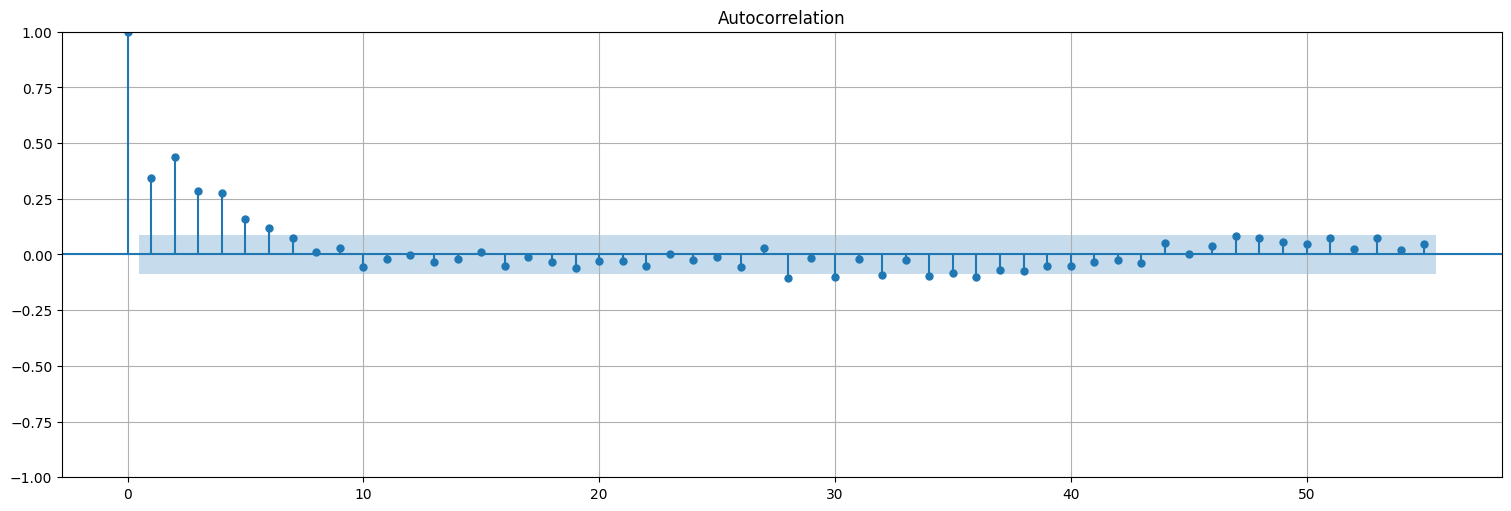

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(fit.resid, bartlett_confint=False, lags=55);

Agreguemos ahora un modelo donde usamos también la variable $P_t^2$ además de $P_t$, para ver cómo el modelo comienza a empeorar en términos del $AIC/BIC$.

In [18]:
#  Modelo 5 (para ver que el AIC/BIC empeora)
P2 = P**2                    # particulas al cuadrado

datos = pd.concat([time,M, temp, temp2, P, P2], axis=1)
datos.columns = ["Semana","Mortalidad", "Temperatura", "Temperatura2", "Particulas", "Particulas2"]

fit = ols(formula="M~Semana+Temperatura+Temperatura2+Particulas+Particulas2", data=datos).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      M   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     148.2
Date:                Tue, 22 Apr 2025   Prob (F-statistic):           2.06e-96
Time:                        15:38:04   Log-Likelihood:                -1659.7
No. Observations:                 508   AIC:                             3331.
Df Residuals:                     502   BIC:                             3357.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       78.9871      2.987     26.445      0.000      73.119      84.855
Semana          -0.0267      0.002    -13.801      0.000      -0.031      -0.023
Temperatura     -0.4756      0.032    -14.955      0.000      -0.538      -0.413
Temperatura2     0.0221      0.003      7.726      0.000       0.017       0.028
Particulas       0.3672      0.121      3.042      0.002       0.130       0.604
Particulas2     -0.0011      0.001     -0.939      0.348      -0.003       0.001
==============================================================================
Omnibus:                       46.388   Durbin-Watson:                   1.309
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.681
Skew:                           0.648   Prob(JB):                     1.22e-15
Kurtosis:                       4.251   Cond. No.                     3.11e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.11e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Ejemplo: Regresión con "lag".

En clases anteriores vimos (a ojo) que existe una relación entre el índice del niño (Southern oscillation index, SOI) y la población de peces (Recruitement).

Recordemos las series:

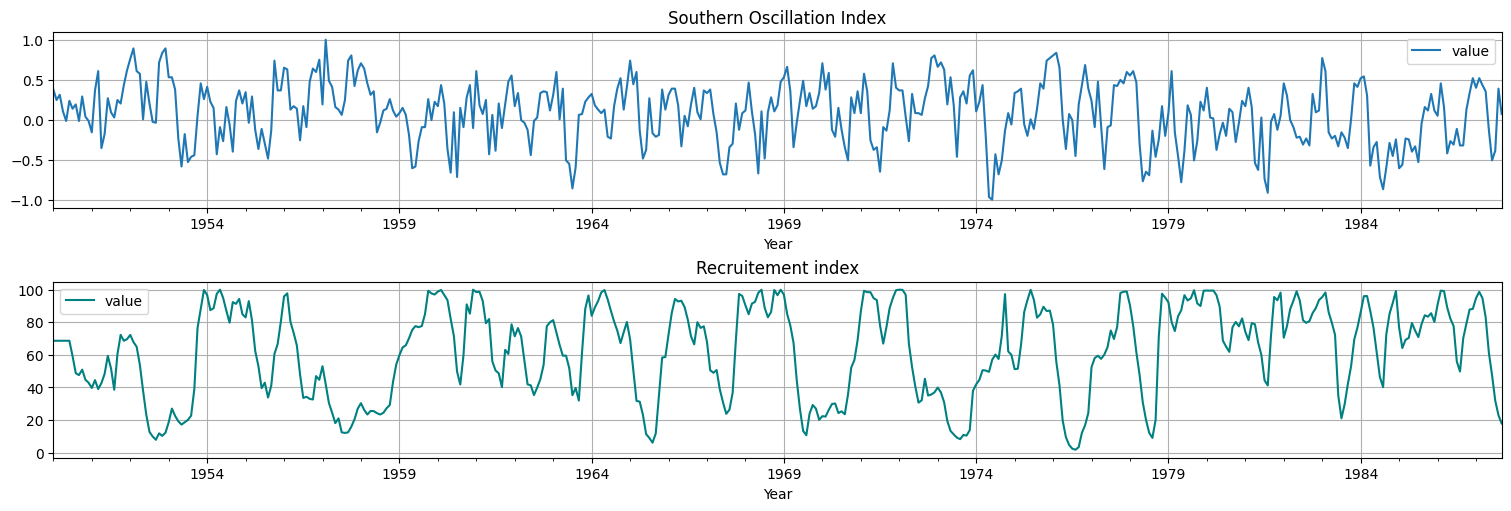

In [19]:
soi = astsa.soi
rec = astsa.rec

fig, axs = plt.subplots(2, 1, constrained_layout = True)
soi.plot(ax=axs[0], xlabel="Year", title="Southern Oscillation Index")
rec.plot(ax=axs[1], xlabel="Year", title="Recruitement index", color="teal");

Analicemos la autocorrelación de cada serie, y la correlación cruzada:

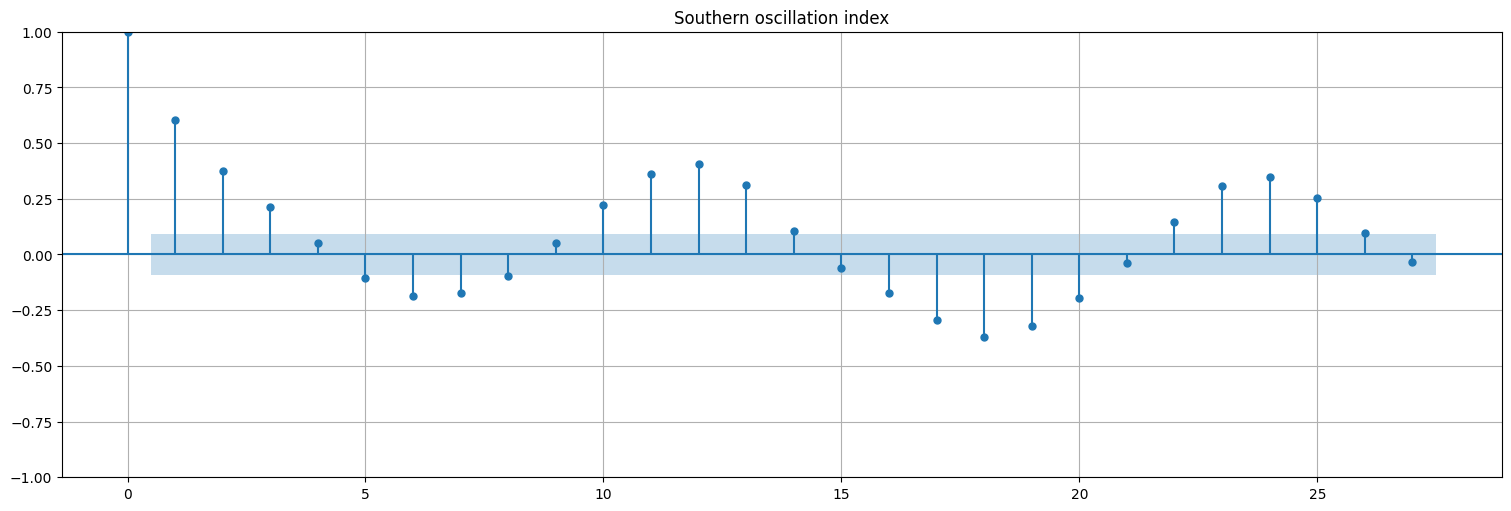

In [20]:
plot_acf(soi, bartlett_confint=False);
plt.title("Southern oscillation index");

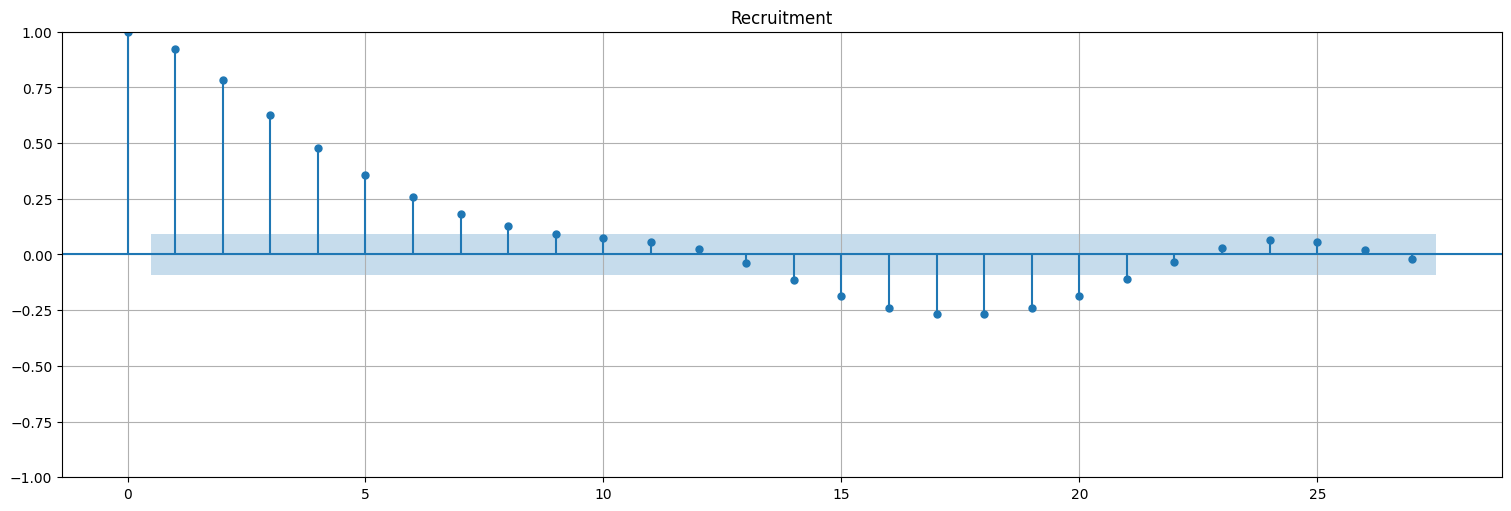

In [21]:
plot_acf(rec, bartlett_confint=False)
plt.title("Recruitment");

### Cálculo de correlación cruzada :
Esta función grafica la correlación cruzada de manera adecuada, considerando lags positivos y negativos,

In [22]:
def ccf(x, y, max_lag, ax=None, **kwargs):
    lags = np.arange(-max_lag, max_lag + 1)

    backwards = sm.tsa.ccf(x[::-1], y[::-1], adjusted=False)[max_lag::-1]
    forwards = sm.tsa.ccf(x, y, adjusted=False)[:max_lag + 1]
    ccf = np.r_[backwards[:-1], forwards]
    ylabel = "CCF"

    if ax is None:
        ax = plt.gca()
    
    ax.stem(lags, ccf, basefmt="k")
    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    conf_level = 1.96 / np.sqrt(x.shape[0])
    ax.fill_between(lags,conf_level,-conf_level,alpha=0.25)
    ax.set_xlabel("LAG")
    ax.set_ylabel(ylabel)

    
    return ax

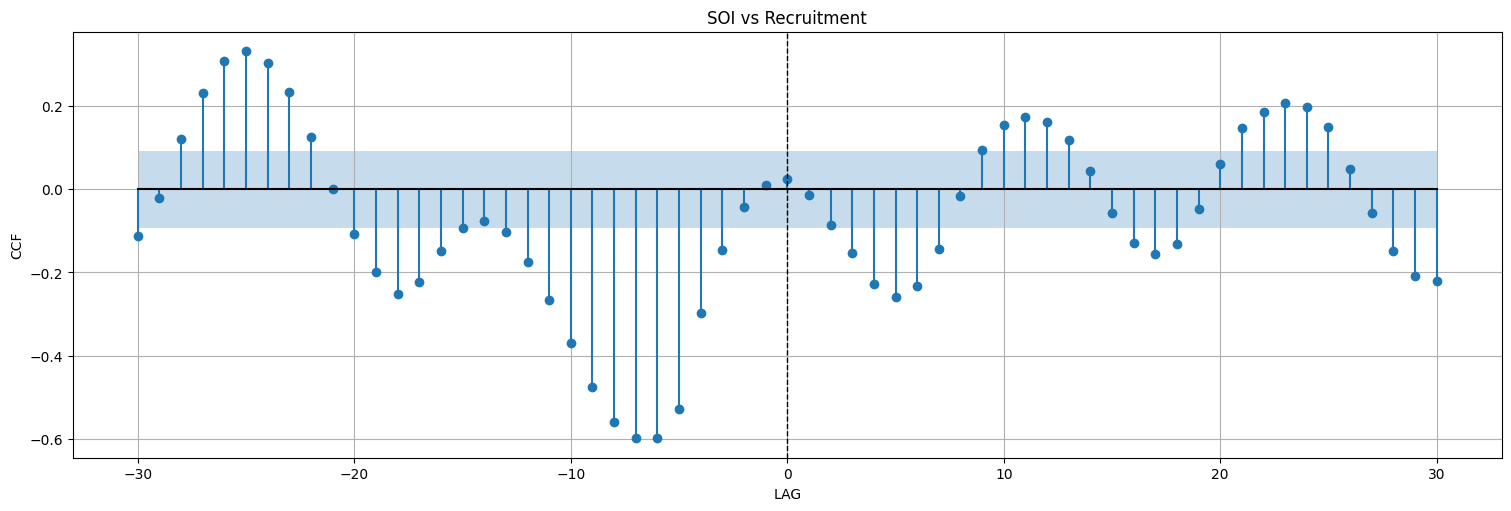

In [23]:
ccf(soi,rec, max_lag=30)
plt.title("SOI vs Recruitment");

**Observaciones:**

* La serie del SOI muestra correlaciones fuertes cada 12 meses.
* El libro dice que la de recruitement también pero yo no las veo (más adelante retomamos esto).
* La correlación cruzada tiene un pico (negativo) en -6 meses. Esto indica que la serie SOI puede predecir la serie de Recruitement usando el valor de 6 meses antes.

Se propone entonces un modelo de la forma:

$$R_t = \beta_0 + \beta_1 S_{t−6} + w_t.$$

Es decir, estimar el recruitement actual por una media más algo que depende del SOI $6$ meses antes. Observemos que esto es un modelo lineal como antes, donde simplmente figuran como "features" el intercept u ordenada en el origen, y los valores de $S$ corridos.

> **Problema:** ¿como logramos alinear la serie $R_t$ en tiempo $t$ y la serie $S_{t-6}$ laggeada?
> 
> Usamos el comando `shift` para correr la serie

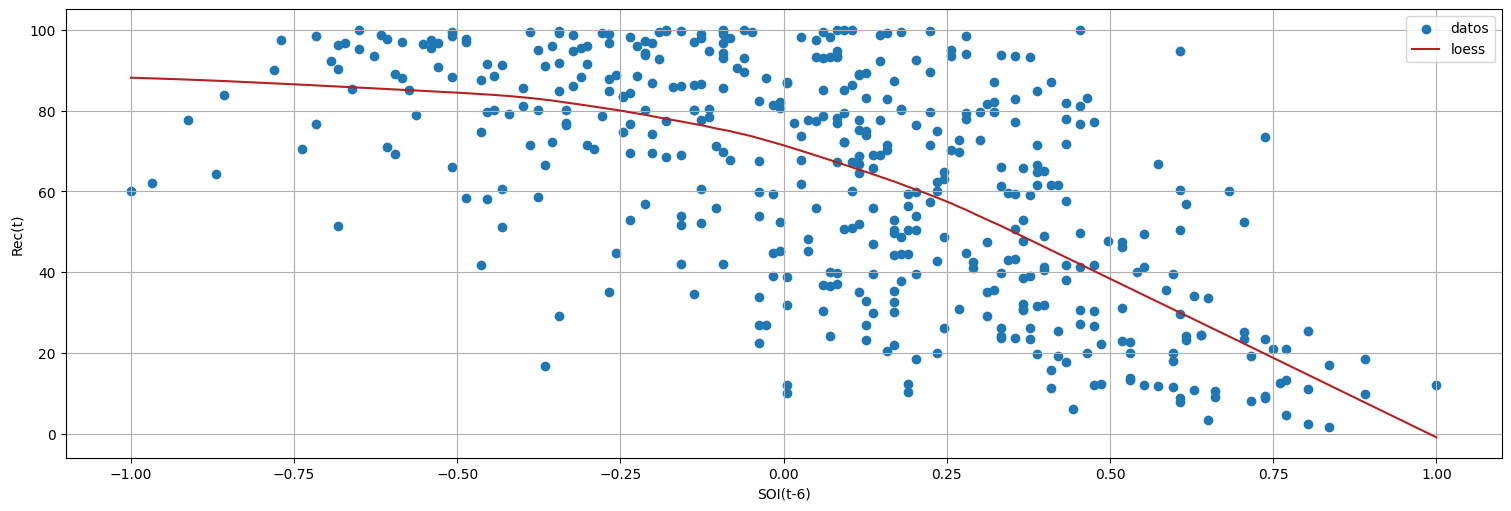

In [24]:
lag=6
plt.scatter(soi.shift(lag), rec, label="datos");
#Agrego un suavizado local para ver la tendencia
lowess = sm.nonparametric.lowess(rec.iloc[:, 0], soi.iloc[:, 0].shift(lag))
plt.plot(lowess[:, 0], lowess[:, 1], color="firebrick", label="loess");
plt.legend()
plt.xlabel("SOI(t-6)")
plt.ylabel("Rec(t)");

**Nota:** la curva roja es una regresión "loess" simple para ver aproximadamente la corelación.

In [25]:
#Podemos llamar a fit haciendo referencia a las columnas del dataframe (fish en este caso).
fish = pd.concat([rec, soi.shift(6)], axis=1).dropna()
fish.columns = ["rec", "soiL6"]

fit = ols("rec ~ soiL6", data=fish).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    rec   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     253.5
Date:                Tue, 22 Apr 2025   Prob (F-statistic):           1.68e-45
Time:                        15:38:05   Log-Likelihood:                -2024.9
No. Observations:                 447   AIC:                             4054.
Df Residuals:                     445   BIC:                             4062.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     65.7898      1.088     60.469      0.000      63.652      67.928
soiL6        -44.2826      2.781    -15.923      0.000     -49.748     -38.817
==============================================================================
Omnibus:                       16.029   Durbin-Watson:                   0.547
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.017
Skew:                          -0.088   Prob(JB):                       0.0182
Kurtosis:                       2.368   Cond. No.                         2.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

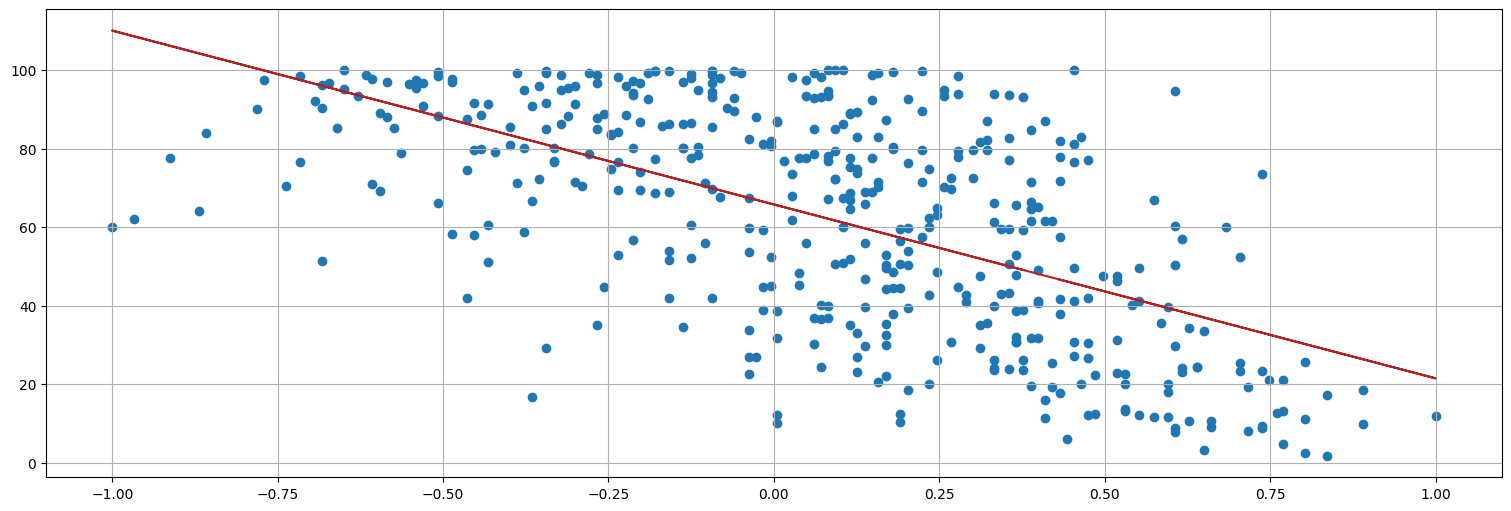

In [26]:
plt.plot(fish.soiL6,fit.fittedvalues, color="firebrick")
plt.scatter(soi.shift(lag), rec);

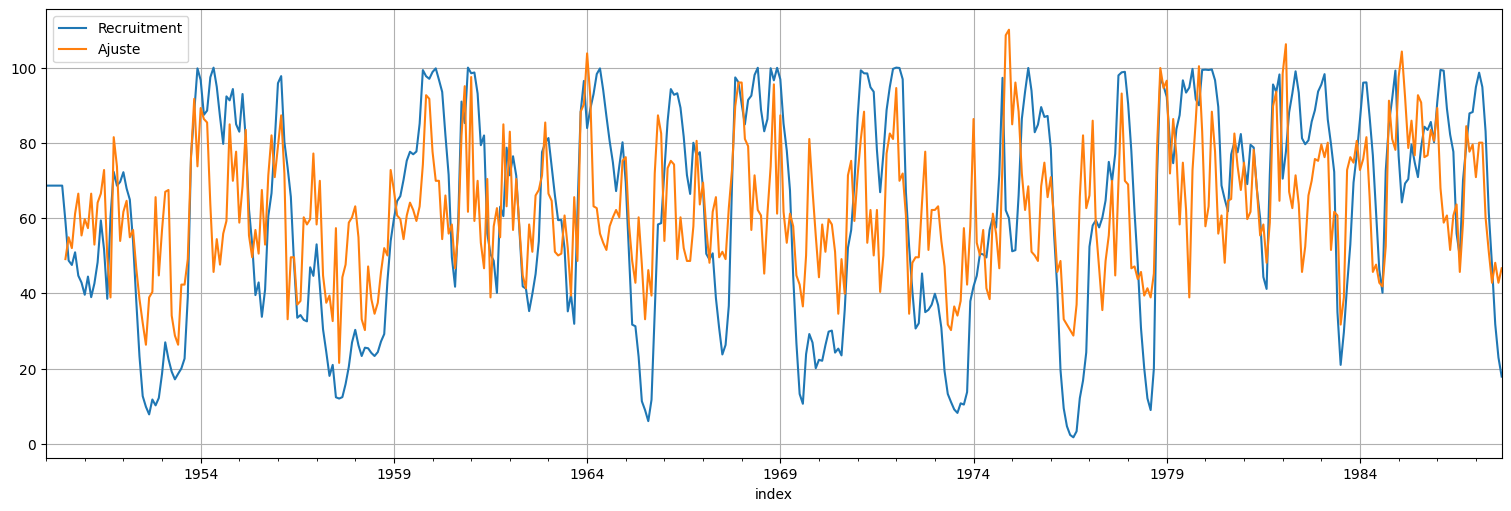

In [27]:
rec.plot()
fit.fittedvalues.plot().legend(["Recruitment","Ajuste"]);

#### Análisis de residuos del ajuste

RMSE del residuo: 22.44678221194104


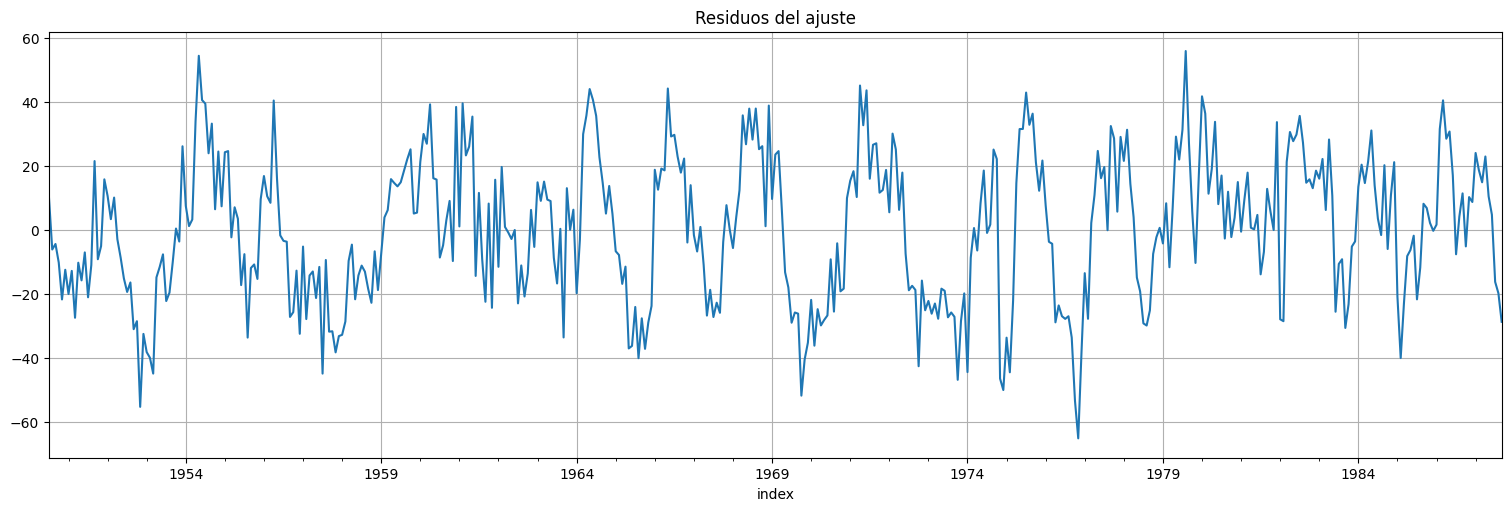

In [28]:
fit.resid.plot();
plt.title("Residuos del ajuste");
print(f"RMSE del residuo: {np.std(fit.resid)}")

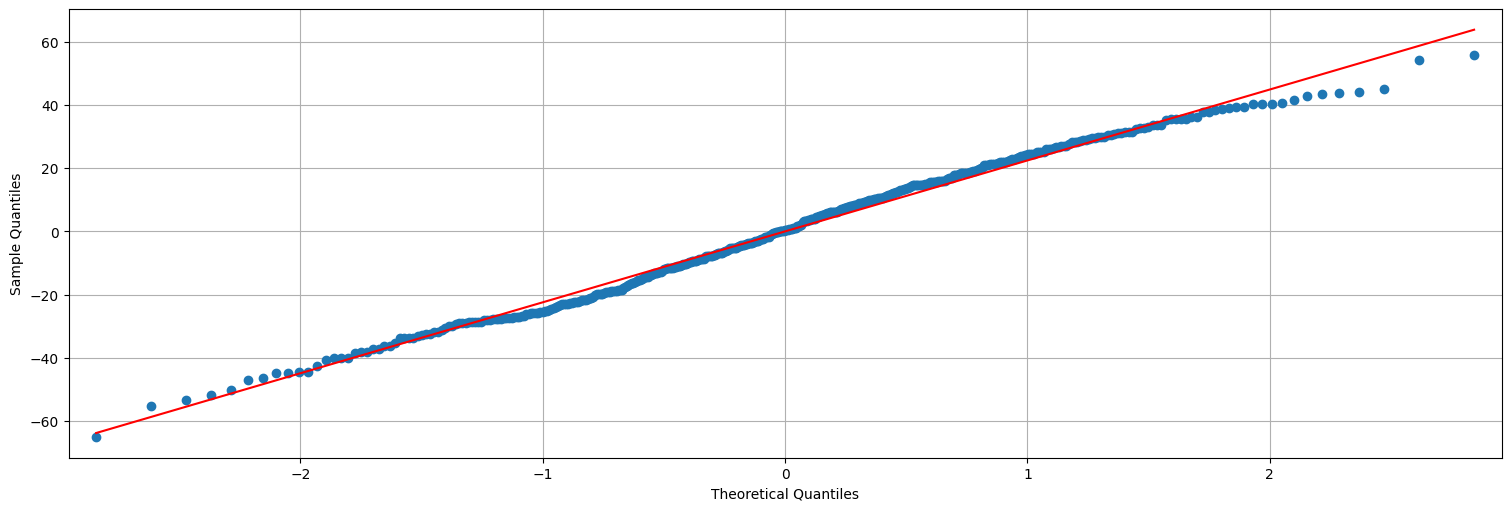

In [29]:
## QQ-plot es una verificación de gaussianidad.
sm.qqplot(fit.resid, line="s");

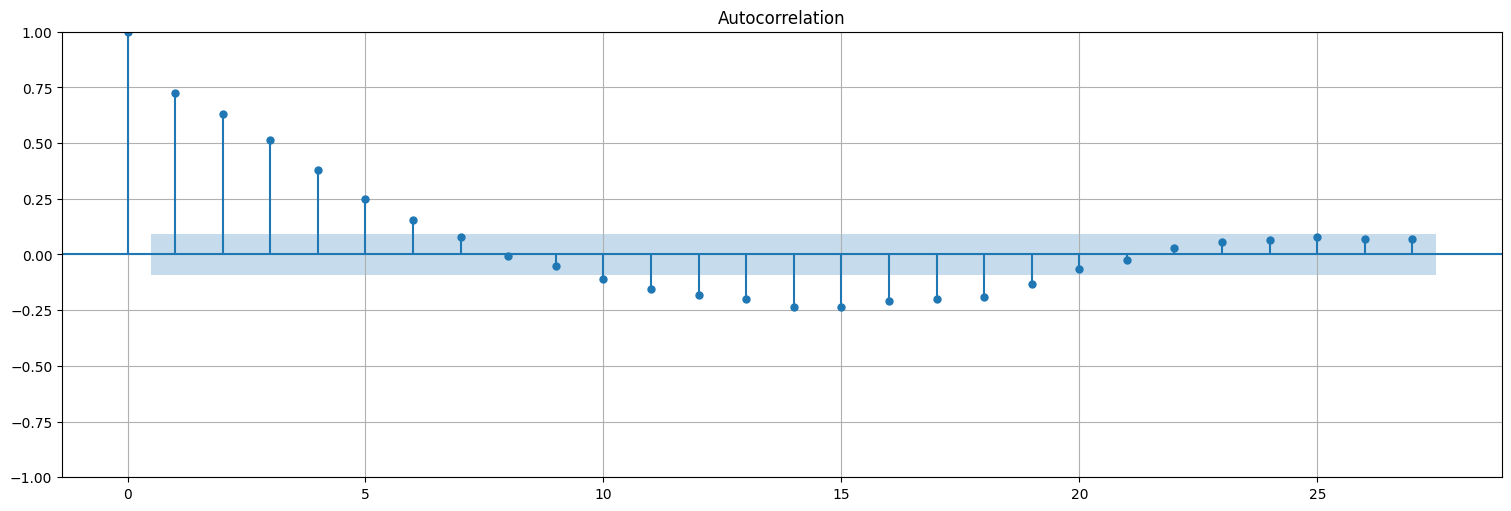

In [30]:
plot_acf(fit.resid, bartlett_confint=False);

### Mejorando el modelo

De la gráfica de $R_t$ vs. $S_{t-6}$ queda claro que el comportamiento es distinto dependiendo de si es positivo o negativo el valor de SOI. Podemos mejorar el modelo incluyendo una variable indicatriz para esto, es decir:

$$R_t = \beta_0 + \beta_1 S_{t-6} + \beta_2 D_{t-6} + \beta_3 S_{t-6}D_{t-6} + w_t$$

siendo $D_t = 1$ si $S_t>0$ y $0$ en otro caso. Esto es equivalente a ajustar dos rectas en las dos regiones.

In [31]:
dummy = soi>0
fish = pd.concat([rec, soi.shift(6), dummy.shift(6)], axis=1).dropna()
fish.columns = ["rec", "soiL6", "DL6"]

fit = ols("rec ~ soiL6+DL6+soiL6*DL6", data=fish).fit()
print(f"RMSE de los residuos: {np.sqrt(fit.mse_resid)}")
fit.summary()

RMSE de los residuos: 21.83859202064757


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    rec   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     99.43
Date:                Tue, 22 Apr 2025   Prob (F-statistic):           3.20e-49
Time:                        15:38:06   Log-Likelihood:                -2010.7
No. Observations:                 447   AIC:                             4029.
Df Residuals:                     443   BIC:                             4046.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            74.4794      2.865     25.998      0.000      68.849      80.110
DL6[T.True]          -1.1394      3.711     -0.307      0.759      -8.433       6.155
soiL6               -15.3583      7.401     -2.075      0.039     -29.904      -0.812
soiL6:DL6[T.True]   -51.2441      9.523     -5.381      0.000     -69.959     -32.529
==============================================================================
Omnibus:                        4.767   Durbin-Watson:                   0.610
Prob(Omnibus):                  0.092   Jarque-Bera (JB):                4.682
Skew:                          -0.215   Prob(JB):                       0.0962
Kurtosis:                       2.741   Cond. No.                         14.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

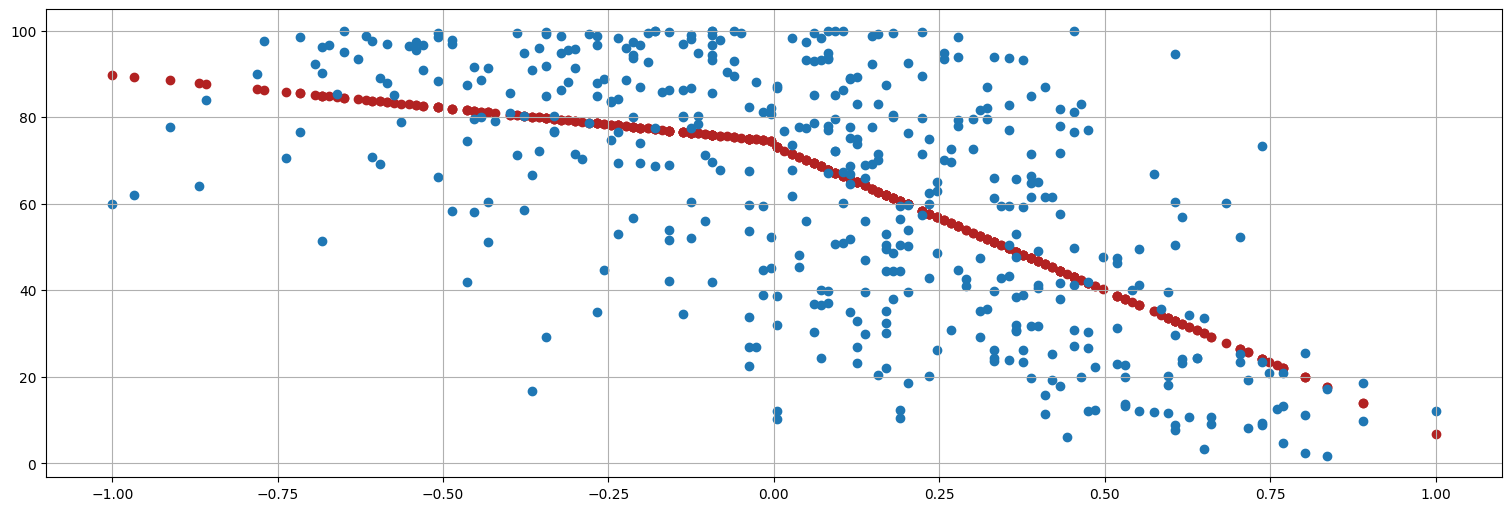

In [32]:
plt.scatter(fish.soiL6,fit.fittedvalues, color="firebrick")
plt.scatter(soi.shift(lag), rec);

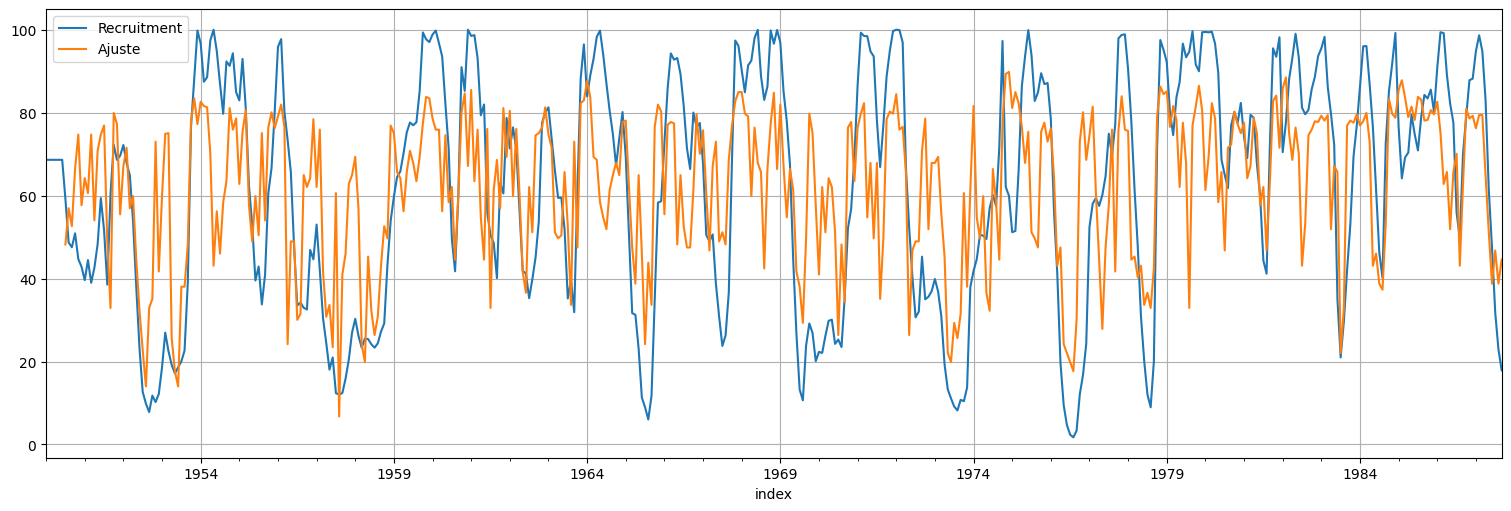

In [33]:
rec.plot()
fit.fittedvalues.plot().legend(["Recruitment","Ajuste"]);

#### Análisis de residuos del ajuste

RMSE del residuo: 21.74066062129114


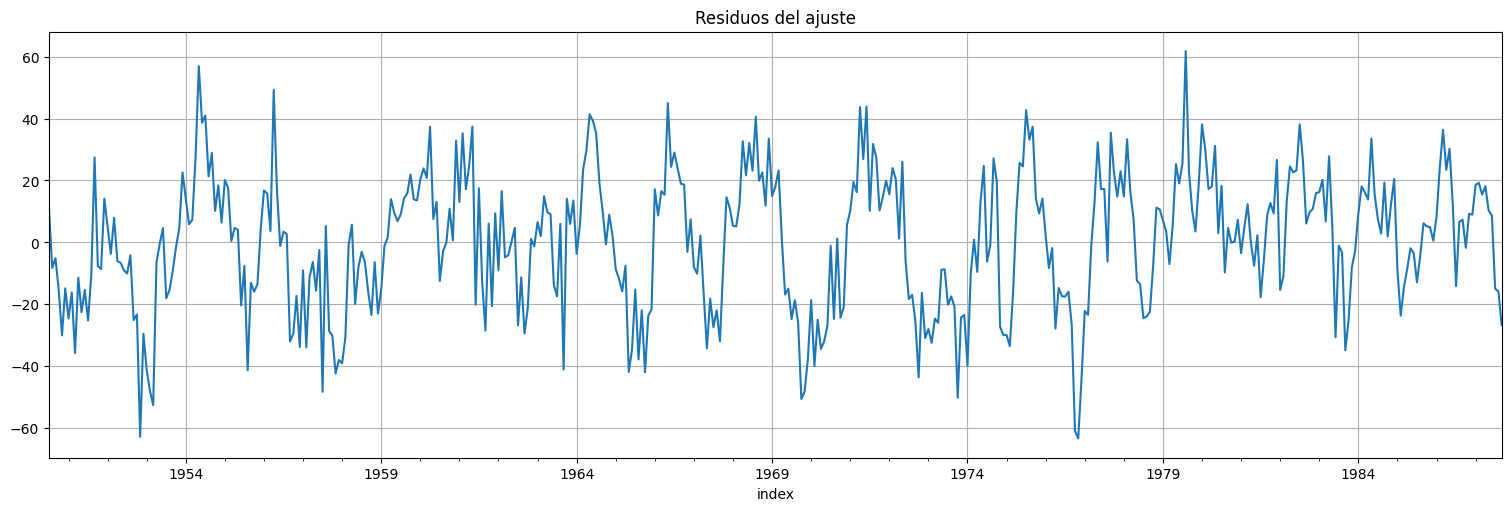

In [34]:
fit.resid.plot();
plt.title("Residuos del ajuste");
print(f"RMSE del residuo: {np.std(fit.resid)}")

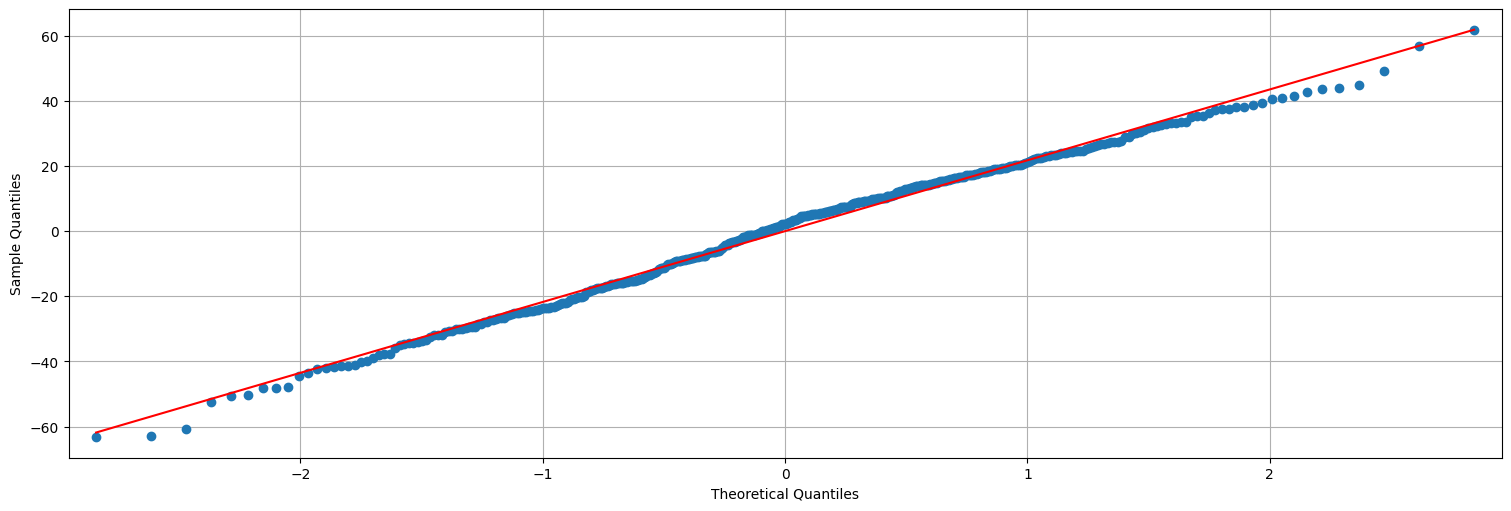

In [35]:
## QQ-plot es una verificación de gaussianidad.
sm.qqplot(fit.resid, line="s");

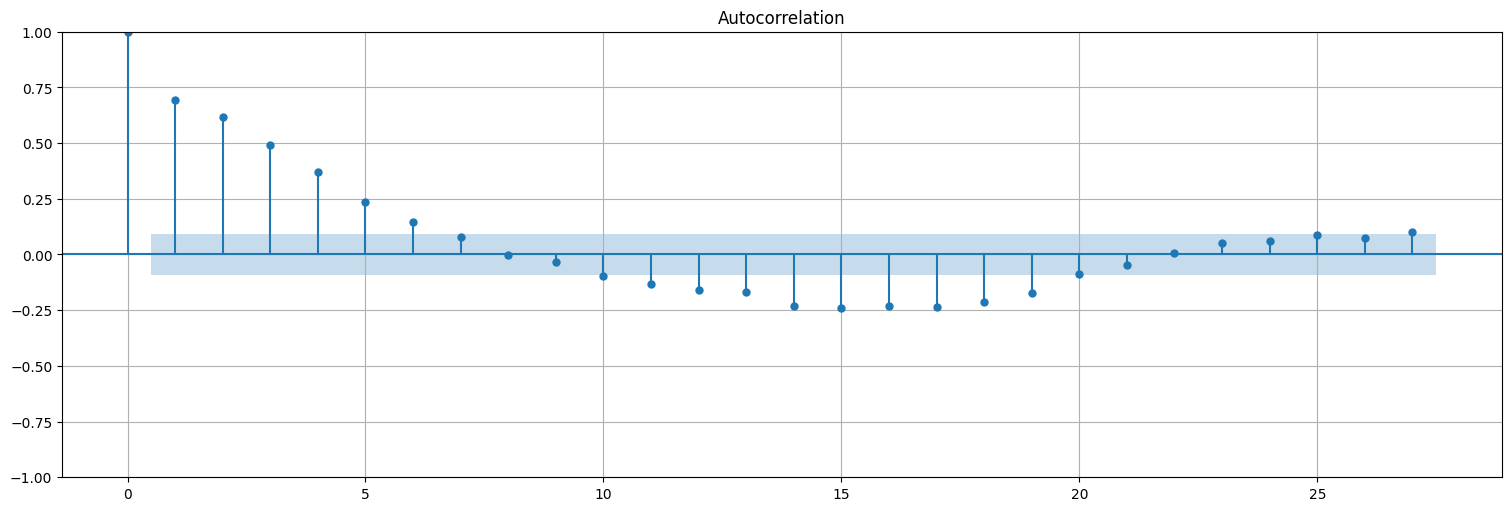

In [36]:
plot_acf(fit.resid, bartlett_confint=False);

## Ejercicios

### Relación entre el precio del petróleo y la gasolina.

Considere las dos series semanales `oil` (precio del petróleo) and `gas` (precio del combustible). La primera está en dólares por barril, la segunda en centavos por galón.

1. Graficar ambas en una misma gráfica. ¿Cuál de los modelos ya vistos se asemeja más? ¿Son estacionarias?

2. En economía, muchas veces la información se encuentra en el porcentaje de cambio de la serie (retorno o tasa de crecimiento). Argumente que la transformación $y_t= \log(x_t) - \log(x_{t-1})$ puede usarse para obtener el retorno.

3. Aplicar la transformación a las series anteriores, volver a graficar y analizar la autocorrelación de las mismas.

4. Graficar la correlación cruzada de las series transformadas. Los valores pequeños pero significativos donde gas adelanta a oil pueden ser considerados "realimentación" entre ellas.

5. Realizar nubes de puntos para las series laggeadas, con hasta 3 semanas de diferencia.

6. Hay estudios que afirman que los precios de combustible responden más rápido a las subidas del petróleo que a las bajadas. Para explorar esto hagamos una regresión con lags simple. 

Sean $G_t$ y $O_t$ las series transformadas de gas y oil respectivamente. Ajuste una regresión:

$$G_t = \alpha_1 + \alpha_2 I_t + \beta_1 O_t + \beta_2 O_{t−1} + w_t,$$

siendo $I_t = 1$ si $O_t \geqslant 0$ y $0$ si no ($I_t$ representa si oil está creciendo). Sugerencia: construir $I$ como en el ejemplo de `soi` visto en clase.

Analizar y discutir los resultados.

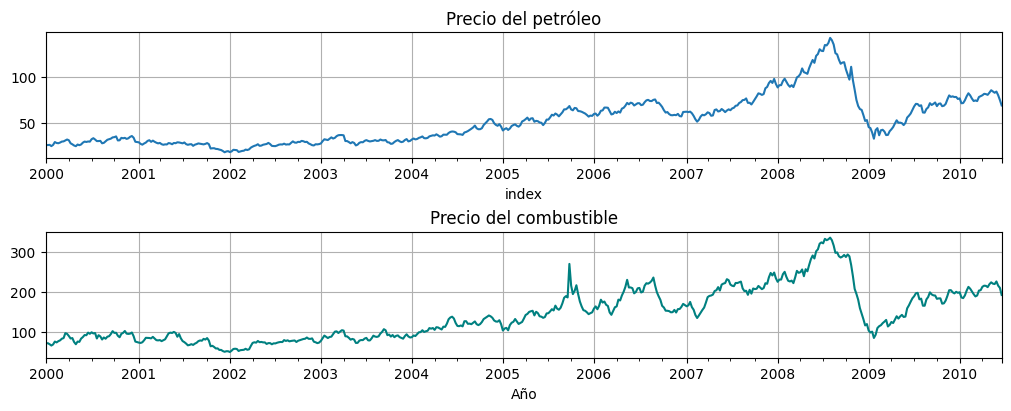

In [37]:
oil=astsa.oil
gas=astsa.gas

fig, axs = plt.subplots(2, 1, figsize=[10,4])
oil.plot(ax=axs[0], title="Precio del petróleo", legend=False)
gas.plot(ax=axs[1], title="Precio del combustible", color="teal", xlabel="Año", legend=False);